## Image segmentation with CamVid

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
from pathlib import PosixPath

Untar the camvid data.

In [4]:
path = untar_data(URLs.CAMVID)

Set two paths: one to the labels at `path_lbl` and one to the images at `path_img`.

In [5]:
path_lbl = path/'labels'
path_img = path/'images'

## Data

Get the image files using `get_image_files`. Print the first three.

In [6]:
img_files = get_image_files(path_img)

In [7]:
img_files[:3]

[PosixPath('/home/paperspace/.fastai/data/camvid/images/0016E5_08093.png'),
 PosixPath('/home/paperspace/.fastai/data/camvid/images/0006R0_f02970.png'),
 PosixPath('/home/paperspace/.fastai/data/camvid/images/0006R0_f01770.png')]

Get the label image files also using `get_image_files`. Print the first three.

In [8]:
lbl_files = get_image_files(path_lbl)
lbl_files[:3]

[PosixPath('/home/paperspace/.fastai/data/camvid/labels/0016E5_08045_P.png'),
 PosixPath('/home/paperspace/.fastai/data/camvid/labels/Seq05VD_f03540_P.png'),
 PosixPath('/home/paperspace/.fastai/data/camvid/labels/0016E5_08117_P.png')]

Show the first image.

In [9]:
doc(open_image)

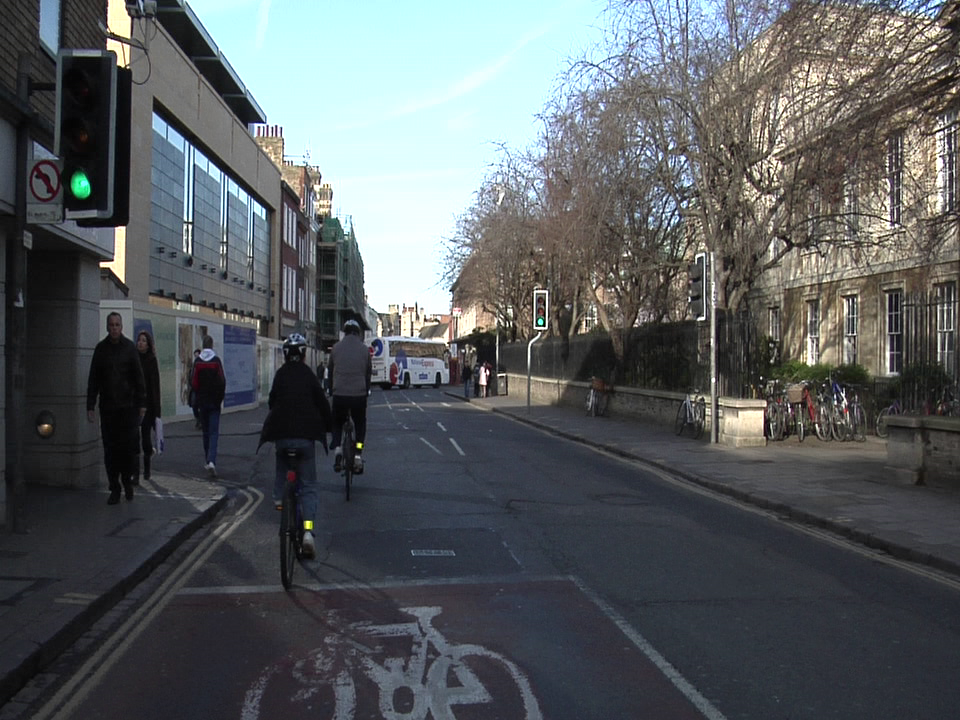

In [10]:
img = open_image(img_files[0]); img

Observe the image names and labels. Write a function that converts a given image name into its corresponding label name.

In [11]:
def image2label(x):
    return path_lbl/f'{x.stem}_P{x.suffix}'

In [12]:
image2label(img_files[0])

PosixPath('/home/paperspace/.fastai/data/camvid/labels/0016E5_08093_P.png')

Use `open_mask` on the mask image name, and show it with the `show` method.

In [13]:
mask = open_mask(image2label(img_files[0]))

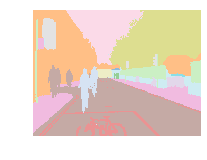

In [14]:
mask.show()

Create a variable called `src_size` with the length and width values of the mask. Print that along with actual mask data values.

In [22]:
src_size = mask.size

Use `np.loadtxt` to load the text values from `path/'codes.txt'`.

In [23]:
! cat {path}/'codes.txt'

Animal
Archway
Bicyclist
Bridge
Building
Car
CartLuggagePram
Child
Column_Pole
Fence
LaneMkgsDriv
LaneMkgsNonDriv
Misc_Text
MotorcycleScooter
OtherMoving
ParkingBlock
Pedestrian
Road
RoadShoulder
Sidewalk
SignSymbol
Sky
SUVPickupTruck
TrafficCone
TrafficLight
Train
Tree
Truck_Bus
Tunnel
VegetationMisc
Void
Wall


In [24]:
codes = np.loadtxt(path/'codes.txt', dtype='str')

## Datasets

Set size to `src_size//2`. Set `bs = 4`. 

In [25]:
size = (src_size[0] // 2, src_size[1] // 2)
bs = 4

Create a `SegmentationItemList` from folder `path_img`, split by fname file `../valid.txt`, label from func `get_y_fn` with `classes=codes`.

In [26]:
! ls {path}

codes.txt  images  labels  valid.txt


In [27]:
src = (SegmentationItemList.from_folder(path_img)
 .split_by_fname_file(path/'valid.txt')
 .label_from_func(image2label, classes=codes))

Turn that into a databunch with standard transforms, `size=size`, `tfm_y=True`, `bs=bs`, and normalize using imagenet stats.

In [28]:
data = (src
        .transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs))

Show a 2x2 batch with figsize 10,7 on the training set.

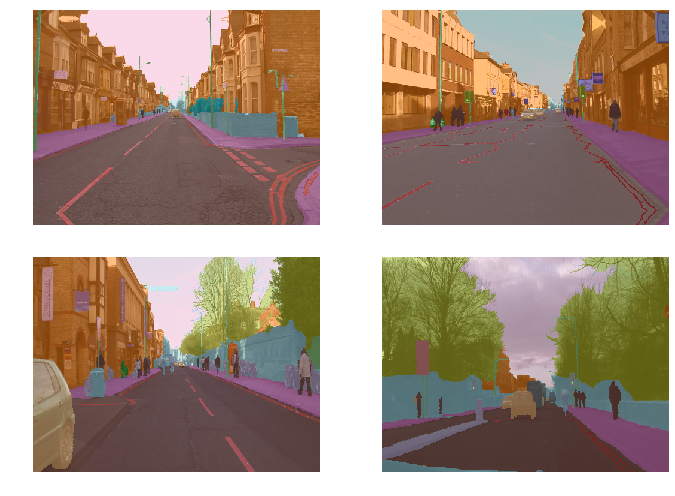

In [29]:
data.show_batch(rows=2, cols=2, figsize=(10,7), ds_type=DatasetType.Train)

Same but validation set.

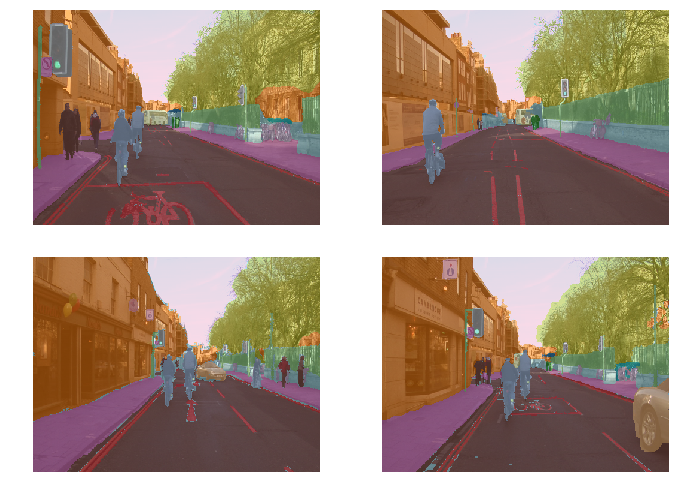

In [30]:
data.show_batch(rows=2, cols=2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

Create a dict `name2id` that maps an enumerated index to each code in the `codes` variable. Bind the variable `void_code` to `name2id['Void']`.

In [31]:
name2id = {val:idx for idx, val in enumerate(codes)}
void_code = name2id['Void']

Create a function `acc_camvid` that takes an input and a target and gets the proportion of pixels where:
* The prediction from `input` matches the target
* The target pixel's code is not equal to `void_code`

In [32]:
a = np.ones([4,1,10,10])
np.concatenate([a, a, a], axis=1).shape

(4, 3, 10, 10)

In [33]:
def acc_camvid(input, target):
#     print(f"input: {input.size()}")
#     print(f"target: {target.size()}")
    mask = target != void_code
#     print(f"mask: {mask.size()}")
    input_cls = tensor(np.expand_dims(np.argmax(input, axis=1), axis=1)).cuda()
    input_filtered = input_cls[mask]
    target_filtered = target[mask]
    return (input_filtered == target_filtered).double().mean()

In [34]:
np.broadcast_to(np.ones([3,3]) * 2, (3,3,3))

array([[[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]],

       [[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]]])

Bind `acc_camvid` to the variable `metrics`.

In [35]:
metrics=acc_camvid

Bind the value `1e-2` to the variable `wd` (for weight decay).

In [36]:
wd=1e-2

Create a `unet_learner` based on the resnet 34 architecture, using the `metrics` and `wd` variables created above.

In [37]:
learn = unet_learner(data, models.resnet34, wd=wd, metrics=metrics)

Run lr_find to determine the appropriate learning raate and plot it.

In [38]:
# learn.lr_find()

In [39]:
# learn.recorder.plot()

The lr should be around `3e-3`.

In [32]:
lr = 3e-3

Fit a cycle with 10 epochs with `slice(lr)`, `pct_start=0.9`.

In [33]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.936375,0.689264,0.832062,03:16
2,0.693850,0.543568,0.859303,03:00
3,0.635182,0.564373,0.862051,03:00
4,0.635568,0.819378,0.816993,03:00
5,0.592559,0.492459,0.870700,03:00
6,0.567352,0.430595,0.878056,03:00
7,0.564311,0.444672,0.888757,03:00
8,0.522438,0.406209,0.884371,03:00
9,0.489205,0.420824,0.877053,03:00
10,0.417033,0.307894,0.911873,03:00


Plot the losses.

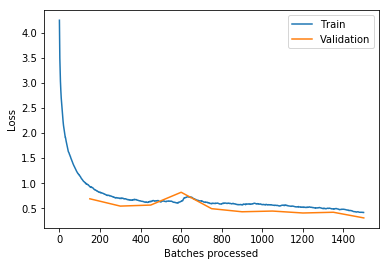

In [34]:
learn.recorder.plot_losses()

Save the weights to `stage-1`.

In [35]:
learn.save('stage-1')

Load the weights from `stage-1`.

In [36]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/paperspace/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /home/paperspace/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

Show 3 rows of results with figsize (8,9).

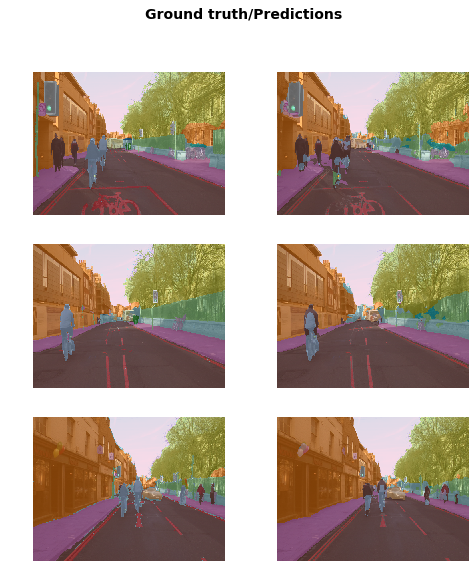

In [41]:
learn.show_results(rows=3, figsize=(8,9))

Unfreeze the model.

In [42]:
learn.unfreeze()

Set a slice of lrs from `lr/400` to `lr/4`.

In [43]:
lrs=slice(lr/400, lr/4)

Fit a cycle with 12 epochs using the new lrs, with `pct_start=0.8`.

In [44]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.373872,0.301070,0.911146,03:10
2,0.362361,0.305393,0.911242,03:10
3,0.365812,0.307249,0.908453,03:09
4,0.351031,0.293625,0.914524,03:10
5,0.336560,0.306717,0.908772,03:10
6,0.330717,0.306557,0.913559,03:10
7,0.319008,0.292179,0.914416,03:10
8,0.325238,0.331774,0.906172,03:10
9,0.324515,0.301027,0.917179,03:10
10,0.313426,0.294013,0.911355,03:10


Save these weights to `stage-2`.

In [45]:
learn.save('stage-2')

## Go big

Set the batch size to 1 (you can try 1-3 if `gpu_mem_get_free_no_cache()` is high enough -- the notebooks suggest using 3 if it's > 8200). 

In [40]:
gpu_mem_get_free_no_cache()

5951

In [41]:
bs=1

Create a databunch from `src` using standard transforms, the new size, transforms on y, batch size equal to whatever is set above, normalized by imagenet stats. Bind it to the name `data`. 

In [42]:
data = (src
        .transform(get_transforms(), size=src_size, tfm_y=True)
        .databunch(bs=bs))

Create a unet learner from `data` using architecture resnet34 with the same metrics and wd as earlier.

In [43]:
learn_big = unet_learner(data, models.resnet34, wd=wd, metrics=metrics)

Load the weights from `stage-2` above.

In [51]:
learn_big.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/paperspace/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/paperspace/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

Use the learning rate finder.

In [52]:
learn_big.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


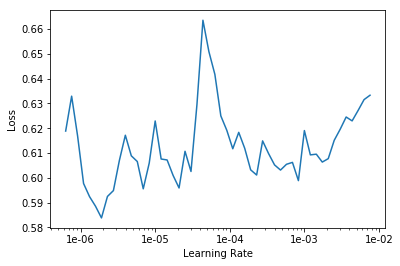

In [54]:
learn_big.recorder.plot()

You should have landed around `1e-3`. Bind the value you found to the `lr` variable.

In [49]:
lr=1e-3

Fit a cycle w/ 10 epochs, using a plain `slice` for lr, with `pct_start=0.8`.

In [ ]:
learn_big.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.429029,0.344880,0.907379,13:56
2,0.385854,0.334707,0.909445,13:54
3,0.346306,0.358898,0.897255,13:56
4,0.337282,0.290375,0.919396,13:55


Save the result to `stage-1-big`.

In [44]:
learn_big.save('stage-1-big')

Load the result from `stage-1-big`.

In [46]:
learn_big.load('stage-1-big')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/paperspace/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /home/paperspace/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

Unfreeze the learner.

In [47]:
learn_big.unfreeze()

Create a new slice of `lrs` going from `1e-6` to `lr/10`.

In [50]:
lrs=slice(1e-6,lr/10)

Fit another cycle of 10 epochs with these lrs.

In [ ]:
learn_big.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
1,0.907965,0.808426,0.811912,14:42


Save the weights to `stage-2-big`.

In [ ]:
learn_big.save('stage-2')

Load the weights from `stage-2-big`.

In [ ]:
learn_big.load('stage-2')

Show 3 rows of results with figsize 10,10.

In [62]:
learn_big.show_results(rows=3, figsize=(10,10))

RuntimeError: CUDA out of memory. Tried to allocate 337.50 MiB (GPU 0; 7.94 GiB total capacity; 4.82 GiB already allocated; 311.44 MiB free; 856.12 MiB cached)